# Saffman, M., et al. "Symmetric Rydberg controlled-Z gates with adiabatic pulses." Physical Review A 101.6 (2020): 062309.

In [8]:
%cd /home/thc/Ubuntu_data/IAMS-Rydberg-atom-quantum-computing
from qutip import *
import math

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from pulseShape import Saffman_shape
from fidelity import fidelity
from optimize.de import de

/home/thc/Ubuntu_data/IAMS-Rydberg-atom-quantum-computing


# Physical system

In [20]:
### Hamiltonian ###
def Hamiltonian(shape_omega1, shape_omega2, shape_delta1, shape_delta):
    rho = []    # 0, 1, p, r, d
    for i in range(5):
        rho.append(ket2dm(basis(5,i)))

    I = qeye(5)

    H_omega1 = np.zeros((5,5))
    H_omega1[2][1] = 2*np.pi / 2
    H_omega1[1][2] = 2*np.pi / 2
    H_omega1 = Qobj(H_omega1)

    H_omega2 = np.zeros((5,5))
    H_omega2[3][2] = 2*np.pi / 2
    H_omega2[2][3] = 2*np.pi / 2
    H_omega2 = Qobj(H_omega2)

    H_delta1 = np.zeros((5,5))
    H_delta1[2][2] = 2*np.pi
    H_delta1 = Qobj(H_delta1)
    
    ### Fix delta2 ###
    H_delta = np.zeros((5,5))
    H_delta[3][3] = 2*np.pi
    H_delta = Qobj(H_delta)

    B = 2*np.pi * 500           # (MHz) Strength of Rydberg states interaction
    Brr = np.zeros((5,5))
    Brr[3][3] = np.sqrt(B)
    Brr = tensor(Qobj(Brr), Qobj(Brr))

    H = [[tensor(H_omega1, I) + tensor(I, H_omega1), shape_omega1], [tensor(H_omega2, I) + tensor(I, H_omega2), shape_omega2], 
        [tensor(H_delta1, I) + tensor(I, H_delta1), shape_delta1], [tensor(H_delta, I) + tensor(I, H_delta), shape_delta],
        [Brr, '1']]

    return H


### Pulse shape omega1(t), omega2(t) and delta1(t) ###
def PulseShape(times, Pulses, T_gate, n_seg):
    Omega1 = Pulses[:6]
    Omega2 = Pulses[6:12]
    Delta1 = Pulses[12:18]
    Delta2 = Pulses[18:]

    def shape_omega1(t, arg):
        return Saffman_shape(t, Omega1, T_gate, n_seg)

    def shape_omega2(t, arg):
        return Saffman_shape(t, Omega2, T_gate, n_seg)

    # Shape of detunning delta1(t)
    def shape_delta1(t, arg):
        return Saffman_shape(t, Delta1, T_gate, n_seg)
    
    def shape_delta(t, arg):
        Delta = [i+Delta2[0] for i in Delta1]
        return Saffman_shape(t, Delta, T_gate, n_seg)
    
    return shape_omega1, shape_omega2, shape_delta1, shape_delta


### Decay term, c_ops ###
def Decay(gammap=1/0.155, gammar=1/540):
    # gammap: (1/mu s) population decay rate of the Rydberg state
    # gammar: (1/mu s) population decay rate of the P state
    c_ops = []
    I = qeye(5)

    L0p = np.zeros((5,5))
    L0p[0][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L0p), I))
    c_ops.append(tensor(I, Qobj(L0p)))

    L0r = np.zeros((5,5))
    L0r[0][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L0r), I))
    c_ops.append(tensor(I, Qobj(L0r)))

    L1p = np.zeros((5,5))
    L1p[1][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L1p), I))
    c_ops.append(tensor(I, Qobj(L1p)))

    L1r = np.zeros((5,5))
    L1r[1][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L1r), I))
    c_ops.append(tensor(I, Qobj(L1r)))

    Ldp = np.zeros((5,5))
    Ldp[4][2] = np.sqrt(7/8 * gammap)
    c_ops.append(tensor(Qobj(Ldp), I))
    c_ops.append(tensor(I, Qobj(Ldp)))

    Ldr = np.zeros((5,5))
    Ldr[4][3] = np.sqrt(7/16 * gammar)
    c_ops.append(tensor(Qobj(Ldr), I))
    c_ops.append(tensor(I, Qobj(Ldr)))

    Lpr = np.zeros((5,5))
    Lpr[2][3] = np.sqrt(1/2 * gammar)
    c_ops.append(tensor(Qobj(Lpr), I))
    c_ops.append(tensor(I, Qobj(Lpr)))

    return c_ops


### Initial state, rhoi() ###
def init_state(rhoc, rhot):
    return tensor(ket2dm(basis(5,rhoc)), ket2dm(basis(5,rhot)))

# Gate Operation

In [21]:
# Gate operation
def GateOp(Pulses, rho_init, targets):
    times = np.linspace(0.0, 1, 100)
    T_gate = 1              # (mu s) Total gate time
    n_seg = 2*len(Omega1)   # Number of segments

    shape_omega1, shape_omega2, shape_delta1, shape_delta = PulseShape(times, Pulses, T_gate, n_seg)
    H = Hamiltonian(shape_omega1, shape_omega2, shape_delta1, shape_delta)
    c_ops = Decay(1/0.155, 1/540)
    
    results = mesolve(H, rho_init, times, c_ops, targets, options=Options(nsteps=10000))
    return results

# Outpout

In [22]:
Omega1 = [1.38, 10.30, 25.54, 42.85, 82.50, 93.35]
Omega2 = [165.09, 199.99, 198.14, 198.87, 200.00, 173.48]
Delta1 = [392.57, 363.48, 364.36, 360.99, 416.45, 420.39]
Delta2 = [-400]
Pulses = Omega1 + Omega2 + Delta1 + Delta2

Had = np.zeros((5,5))
Had[0][0] = 1
Had[0][1] = 1
Had[1][0] = 1
Had[1][1] = -1

I = qeye(5)
Had = Qobj(Had/np.sqrt(2))
bell10 = (1/np.sqrt(2)) * ( tensor(basis(5,0), basis(5,1)) + tensor(basis(5,1), basis(5,0)) )

rho_bell10 = tensor(I, Had) * ket2dm(bell10) * tensor(I, Had)
rhoi = tensor(Had, Had) * init_state(0,1) * tensor(Had, Had)

bell_fidelity = fidelity(GateOp, rhoi, rho_bell10)
print(bell_fidelity.get_fidelity(Pulses))

0.8549787803521273


# Differentail Evolution

In [23]:
K = len(Pulses)
diffevo = de(bell_fidelity, K, 0, 500)
diffevo.start(10000)

# 0.
Optimized Fidelity: 0
Fidelity (Ci, Di) = 0.14667957763354694 0.07819880737800565
Replace vector 192
# 1.
Optimized Fidelity: 0.14667957763354694
Fidelity (Ci, Di) = 0.1254150070366541 0.042514682387354445
Replace vector 33
# 2.
Optimized Fidelity: 0.14667957763354694
Fidelity (Ci, Di) = 0.09943694380436413 0.03714575855875398
Replace vector 269
# 3.
Optimized Fidelity: 0.14667957763354694
Fidelity (Ci, Di) = 0.24003961741436203 0.31705132556498156
Vector 230 unchanged
# 4.
Optimized Fidelity: 0.31705132556498156
Fidelity (Ci, Di) = 0.20269220569135518 0.07326316393508384
Replace vector 131
# 5.
Optimized Fidelity: 0.31705132556498156
Fidelity (Ci, Di) = 0.10816252912813201 0.0316996884081795
Replace vector 19
# 6.
Optimized Fidelity: 0.31705132556498156
Fidelity (Ci, Di) = 0.2130938171159875 0.15005102938131895
Replace vector 24
# 7.
Optimized Fidelity: 0.31705132556498156
Fidelity (Ci, Di) = 0.018231848192643355 0.19715115095377486
Vector 240 unchanged
# 8.
Optimized Fidelity: 0

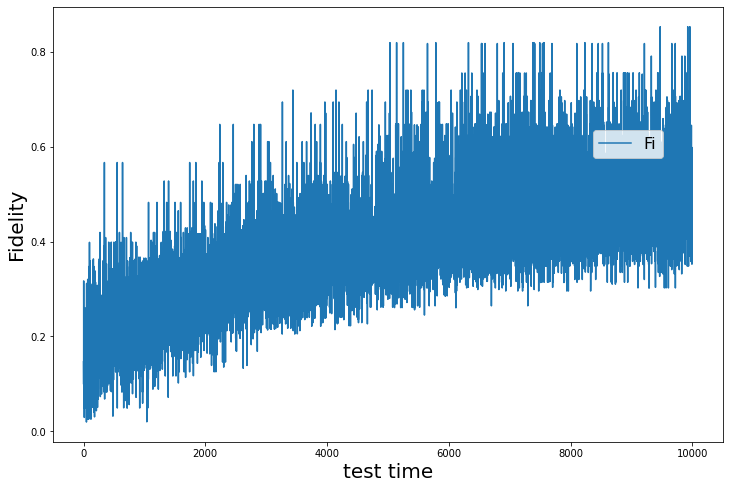

In [24]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(diffevo.data_fidelity, label="Fi")

ax1.set_xlabel("test time", fontsize=20) 
ax1.set_ylabel("Fidelity", fontsize=20)

fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)